https://www.kaggle.com/code/sanabdriss/nlp-extract-skills-from-job-Job_descriptions

This project consists of finding a correlation between job descriptions and skills.

# 3. Analyze Knowledge, Skills, and Tasks from Job Descriptions

## 1. Import packages

In [103]:
# pip install numpy pandas sklearn wordcloud Descriptionblob

In [104]:
import numpy as np # linear algebra
import pandas as pd # data processing, json file I/O (e.g. pd.read_json)
import string
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

import os

## 2. Import Data

In [105]:
test = pd.read_csv('../data/project_data/data-jobs-20221123.csv', encoding='utf-8')

## Delete empty rows
test = test.dropna()

print("\n ** raw data **\n")
print(test.head())
print("\n ** data shape **\n")
print(test.shape)


 ** raw data **

                                           job_title       role  \
0  Business Intelligence Engineer, Identity and A...   engineer   
1                         Data Integration Developer  developer   
2  Identity and Access Management (IDAM) Operatio...    analyst   
3  Identity and Access Management Engineer - IAM ...   engineer   
4           ServiceNow Developer (All Levels Remote)  developer   

                                         description  
0  · 3+ years in relevant experience as Business ...  
1  · Using API connections and flat files ingests...  
2  ** NO Corp-to-Corp**\n\n\nMust be local or wil...  
3  **REMOTE OPPORTUNITY**\r\n\r\nEmBark is curren...  
4  *We are open to supporting 100% remote work an...  

 ** data shape **

(452, 3)


## 3. Plot Roles

<AxesSubplot: >

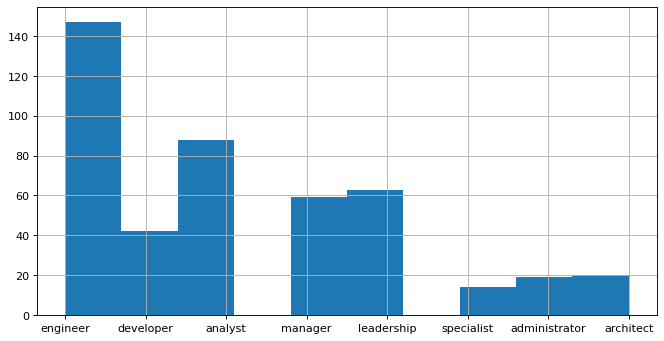

In [106]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
test.role.hist()

## 4. Process Data

In [107]:
## Lower case
test['description'] = test['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['description'] = test['description'].str.replace('[^\w\s]',' ', regex=True)
## digits
test['description'] = test['description'].str.replace('\d+', ' ', regex=True)

#remove stop words
stop = stopwords.words('english')
other_stop_words = ['and','experience','show','veteran','less','origin','sexual', 'orientation', 'dental', 'insurance', 'hour', 'shift','religion','sex','receive','consideration','pay', 'per','employment','opportunity','consideration', 'employment','job','description','start', 'job','click','gender','benefits', 'k','monday', 'friday','age', 'disability','please', 'visit','salary', 'range','characteristic', 'protected','minimum', 'qualifications','join','reasonable', 'accommodation', 'parental', 'leave', 'medical', 'vision', 'duties', 'responsibilities','business', 'needs','essential', 'functions','color','type', 'fulltime','verbal', 'communication','apply','work','national', 'status','closely','flexible', 'spending','’','ability', 'work','location', 'remote','capital', 'one','marital', 'status','team', 'members','work', 'location','applicants', 'without','paid', 'time','color','regard', 'race','apply','equal', 'employer','without', 'regard','united', 'states',"'s",'race', 'color','best', 'practices','physical', 'mental','health', 'savings','responsible','affirmative', 'action','iam','federal','state','local','required','ideal', 'candidate','individuals', 'disabilities','northrop', 'grumman','applicable', 'law','every', 'day','across', 'organization''travel', 'required','track', 'record''including', 'limited','employee', 'assistance','new', 'york','compensation', 'package','financial', 'services','travel', 'requirements','including','provide','process','technology']

technical_words = ['support','system','environment','engineer','administrator','director','analyst', 'architect','specialist','developer','']

stop.extend(other_stop_words + technical_words)

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
test['description'] = test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
test.head()


Preprocessed data: 



,job_title,role,description
0,"Business Intelligence Engineer, Identity and A...",engineer,year relevant intelligence data data scientist...
1,Data Integration Developer,developer,using api connection flat file ingests parse j...
2,Identity and Access Management (IDAM) Operatio...,analyst,corp corp must willing relocate expense positi...
3,Identity and Access Management Engineer - IAM ...,engineer,embark currently seeking experienced specific ...
4,ServiceNow Developer (All Levels Remote),developer,open supporting anywhere within u icf data mod...


## 5. Aggregate descriptions by role

In [108]:
## jda stands for job description aggregated
jda = test.groupby(['role']).sum().reset_index()
print("Aggregated job descriptions: \n")

jda.head()

Aggregated job descriptions: 



,role,job_title,description
0,administrator,Systems Administrator IIdentity Access Managem...,announcement detail open date requisition numb...
1,analyst,Identity and Access Management (IDAM) Operatio...,corp corp must willing relocate expense positi...
2,architect,Principal Foundational Architect‚ÄîIdentity & ...,become part nike inc nike inc outfit world äôs...
3,developer,Data Integration DeveloperServiceNow Developer...,using api connection flat file ingests parse j...
4,engineer,"Business Intelligence Engineer, Identity and A...",year relevant intelligence data data scientist...


## 6. Word cloud of each role


*** administrator ***



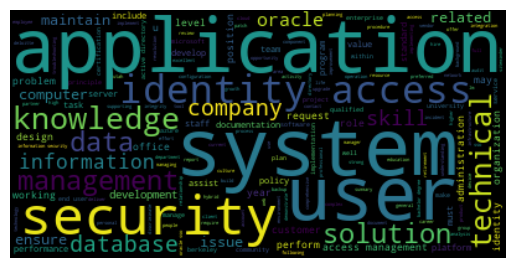


*** analyst ***



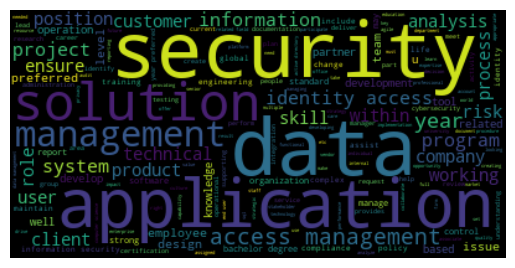


*** architect ***



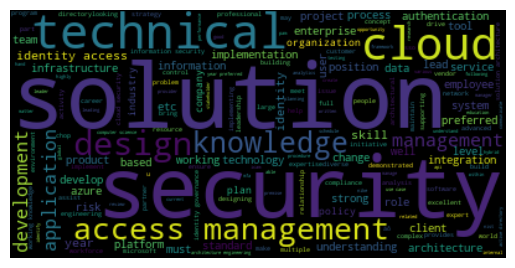


*** developer ***



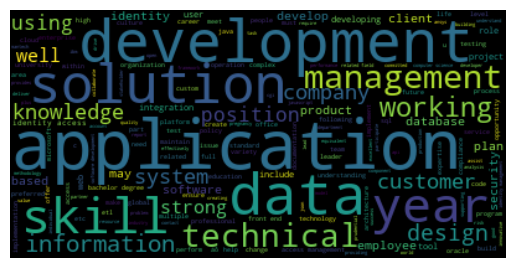


*** engineer ***



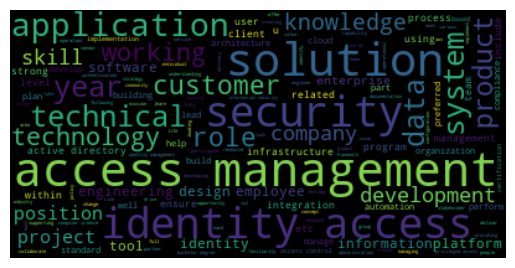


*** leadership ***



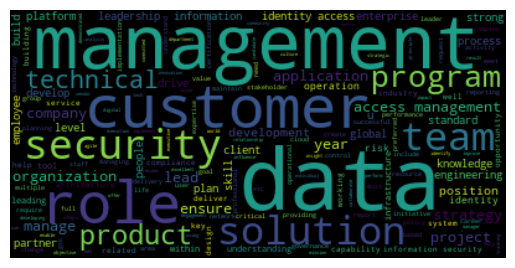


*** manager ***



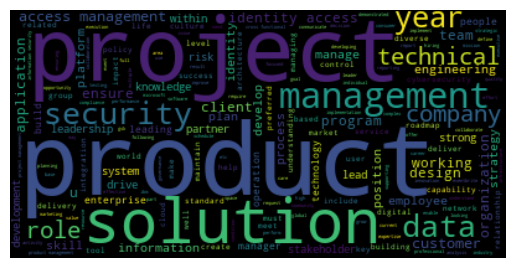


*** specialist ***



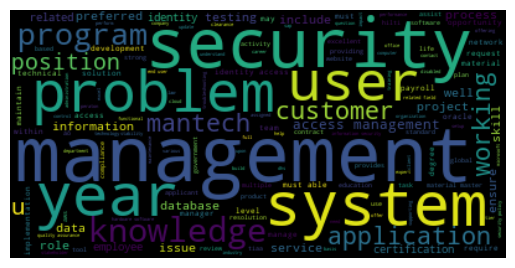

In [109]:
## Visualize data
jobs_list = jda.role.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.role == job].iloc[0].description

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


## 7. Model

In [110]:
## Converting text to features 
vectorizer = TfidfVectorizer(min_df=0.14, max_df=0.5, max_features=500)
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.description)
y = test.role

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (361, 400)
test data shape:  (91, 400)


<AxesSubplot: >

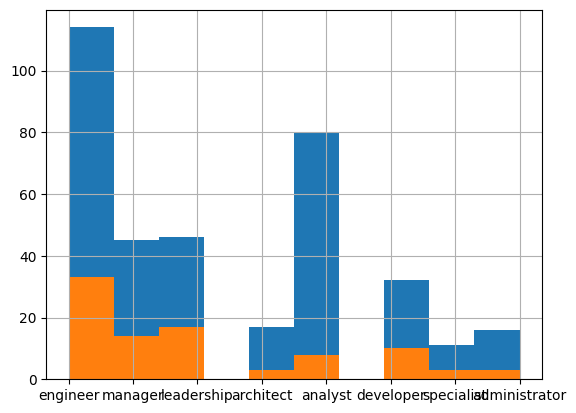

In [111]:
y_train.hist()
y_test.hist()

In [112]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.4725274725274725
Classes: (to help read Confusion Matrix)
 ['administrator' 'analyst' 'architect' 'developer' 'engineer' 'leadership'
 'manager' 'specialist']
Confusion Matrix: 
[[ 0  0  0  0  3  0  0  0]
 [ 0  3  0  0  5  0  0  0]
 [ 0  0  0  0  3  0  0  0]
 [ 0  0  0  1  8  1  0  0]
 [ 0  2  0  0 31  0  0  0]
 [ 0  4  0  0  5  7  1  0]
 [ 0  6  0  0  5  2  1  0]
 [ 0  1  0  0  2  0  0  0]]
Classification Report: 
               precision    recall  f1-score   support

administrator       0.00      0.00      0.00         3
      analyst       0.19      0.38      0.25         8
    architect       0.00      0.00      0.00         3
    developer       1.00      0.10      0.18        10
     engineer       0.50      0.94      0.65        33
   leadership       0.70      0.41      0.52        17
      manager       0.50      0.07      0.12        14
   specialist       0.00      0.00      0.00         3

     accuracy                           0.47        91
    mac

/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


At this step, we have for each class/job a list of the most representative words/tokens found in job descriptions.

Let's shrink this list of words to only:

6 technical skills
6 adjectives
To do so, we use the library TextBlob to identify adjectives.

Also, given a (non-exhaustive) list of programming languages, we can extract the top technical skills.

In [113]:
from textblob import TextBlob
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn','numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow','linux','ruby','javaScript','django','react','reactjs','ai','ui','tableau', 'directory', 'virtual directory', 'radiant logic', 'sailpoint', 'identity proofing', 'identity aggregations', 'identity lifecycle management', 'deprovisioning', 'account management', 'entitlements', 'attribute management', 'reconciliation', 'resolution', 'identity management', 'ldap','active directory', 'azure active directory', 'ad', 'aad', 'mim', 'microsoft identity manager', 'access reviews', 'identity governance and administration', 'identity governance', 'iga', 'recertification', 'entrust', 'venafi', 'one time pin', 'otp' 'FIDO', 'pki', 'enrollment', 'credential management', 'password', 'push notification', 'okta', 'ping', 'single sign-on', 'SSO', 'public key infrastructure', 'authentication', 'authorization', 'access management', 'abac', 'access control', 'saml', 'oidc', 'open id connect', 'active directory federation services', 'adfs', 'policy decision point', 'two-factor authentication', 'tfa', 'mfa', 'multifactor authentication', 'privileged access management', 'pam', 'cyberark', 'beyondtrust', 'thycotic',  'privileged account management', 'policy alignment', 'authentication broker', 'attribute exchange', 'trust framework', 'assertion service', 'federation assertion', 'saml', 'oidc', 'open id connect', 'security token service', 'sts', 'trust relationship', 'azure', 'aws', 'directory','iam', 'directory']
feature_array = vectorizer.get_feature_names_out()
# number of overall model features
features_numbers = len(feature_array)
## max sorted features number
n_max = int(features_numbers * 0.1)

##initialize output dataframe
output = pd.DataFrame()
for i in range(0,len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)
    
    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:6]
    #print("Top technical skills",top_technical_skills)
    
    ## Extract adjectives
    
    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    #raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    #raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:6]
    #print("Top 6 adjectives: ",top_adjectives)
    
    output = output.append({'title':clf.classes_[i],
                        'technical_skills':top_technical_skills,
                        'soft_skills':top_adjectives },
                       ignore_index=True)


**** administrator ****

list of unprocessed skills :
['computer' 'administration' 'directory' 'sso' 'maintain' 'must' 'assist'
 'perform' 'personal' 'active' 'account' 'software' 'office' 'issue'
 'azure' 'certification' 'task' 'microsoft' 'policy' 'performance'
 'contract' 'end' 'least' 'staff' 'site' 'configuration' 'department'
 'audit' 'problem' 'server' 'hybrid' 'saml' 'may' 'documentation'
 'request' 'culture' 'monitor' 'document' 'summary' 'principle']

**** analyst ****

list of unprocessed skills :
['analysis' 'client' 'risk' 'must' 'procedure' 'cybersecurity'
 'compliance' 'operation' 'control' 'partner' 'issue' 'may'
 'administration' 'well' 'assist' 'policy' 'equivalent' 'training'
 'concept' 'quality' 'governance' 'reporting' 'field' 'contract' 'group'
 'schedule' 'help' 'manager' 'education' 'perform' 'change' 'software'
 'directory' 'audit' 'request' 'standard' 'identify' 'employee' 'problem'
 'implementation']

**** architect ****

list of unprocessed skills :
['archi

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],



**** developer ****

list of unprocessed skills :
['sql' 'web' 'database' 'client' 'using' 'server' 'developing' 'software'
 'code' 'integration' 'may' 'platform' 'end' 'office' 'well' 'cloud'
 'employee' 'test' 'offer' 'world' 'qualified' 'education' 'etc' 'testing'
 'computer' 'help' 'technology' 'issue' 'agile' 'need' 'full' 'upon'
 'also' 'must' 'resource' 'java' 'microsoft' 'meet' 'unit' 'plus']

**** engineer ****

list of unprocessed skills :
['directory' 'technology' 'platform' 'engineering' 'azure' 'cloud'
 'active' 'control' 'authentication' 'software' 'enterprise' 'integration'
 'architecture' 'infrastructure' 'sailpoint' 'risk' 'must' 'privileged'
 'governance' 'policy' 'account' 'manager' 'certification'
 'implementation' 'cybersecurity' 'client' 'service' 'linux' 'ad'
 'provisioning' 'employee' 'operation' 'compliance' 'etc' 'using'
 'problem' 'sso' 'standard' 'build' 'life']

**** leadership ****

list of unprocessed skills :
['lead' 'leadership' 'strategy' 'control' 'm

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_34156/230416292.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [114]:
print(output.T)

                                                                  0  \
title                                                 administrator   
technical_skills                           [saml, directory, azure]   
soft_skills       [sso, perform, personal, active, microsoft, le...   

                                     1  \
title                          analyst   
technical_skills           [directory]   
soft_skills       [assist, equivalent]   

                                                               2  \
title                                                  architect   
technical_skills          [ad, authentication, directory, azure]   
soft_skills       [lead, etc, initiative, full, large, schedule]   

                                                 3  \
title                                    developer   
technical_skills                       [sql, java]   
soft_skills       [server, cloud, full, microsoft]   

                                                        